# Word2Vec

In [0]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

In [0]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [0]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [0]:
# Use Defaults (this make take awhile!!)
words = fetch_words_data()

In [5]:
len(words)

17005207

In [6]:
words[7000:7040]

['org',
 'wikipedia',
 'page',
 'industrial',
 'workers',
 'of',
 'the',
 'world',
 'anarchism',
 'forms',
 'of',
 'government',
 'political',
 'ideology',
 'entry',
 'points',
 'political',
 'theories',
 'social',
 'philosophy',
 'autism',
 'is',
 'classified',
 'as',
 'a',
 'neurodevelopmental',
 'disorder',
 'that',
 'manifests',
 'itself',
 'in',
 'markedly',
 'abnormal',
 'social',
 'interaction',
 'communication',
 'ability',
 'patterns',
 'of',
 'interests']

In [7]:
for w in words[7000:7040]:
    print(w, end=' ')

org wikipedia page industrial workers of the world anarchism forms of government political ideology entry points political theories social philosophy autism is classified as a neurodevelopmental disorder that manifests itself in markedly abnormal social interaction communication ability patterns of interests 

In [0]:
from collections import Counter

In [0]:
my_list = ['one', 'two', 'two']

In [10]:
Counter(my_list)

Counter({'one': 1, 'two': 2})

In [11]:
Counter(my_list).most_common()

[('two', 2), ('one', 1)]

In [0]:
def create_counts(vocab_size=50000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [0]:
vocab_size = 50000

In [0]:
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)

In [15]:
data[0]

5233

In [16]:
(words[100],data[100])

('interpretations', 4186)

In [17]:
vocabulary.shape

(50000,)

In [18]:
vocabulary[np.random.randint(0,50000)]

'eine'

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [0]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [21]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080], dtype=int32)

In [22]:
labels

array([[5233],
       [  11],
       [5233],
       [  11],
       [5233],
       [  11],
       [5233],
       [  11]], dtype=int32)

In [0]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2    

In [0]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

In [0]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [0]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [0]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [29]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

W0628 00:49:41.483073 140381583255424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [31]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

W0628 00:49:41.840962 140381583255424 deprecation.py:506] From <ipython-input-31-02a02e7006c1>:1: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Add variable initializer.
init = tf.global_variables_initializer()

In [33]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 200001

with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  281.9224548339844
Average loss at step  1000 :  10360.91126828003
Average loss at step  2000 :  22312.62458971405
Average loss at step  3000 :  25885.43162732315
Average loss at step  4000 :  31158.753467704773
Average loss at step  5000 :  34891.81799882347
Average loss at step  6000 :  38790.58013304138
Average loss at step  7000 :  39620.80855450058
Average loss at step  8000 :  44637.49135091298
Average loss at step  9000 :  44750.02003367901
Average loss at step  10000 :  45335.28969741058
Average loss at step  11000 :  46132.827317570926
Average loss at step  12000 :  51531.60104101562
Average loss at step  13000 :  45422.59121802998
Average loss at step  14000 :  42065.60302132416
Average loss at step  15000 :  45397.97824274826
Average loss at step  16000 :  45560.23375078736
Average loss at step  17000 :  41388.02443053913
Average loss at step  18000 :  42584.09812866592
Average loss at step  19000 :  42782.05268472672
Average loss at step  20000 :  

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [36]:
type(final_embeddings)

numpy.ndarray

In [37]:
final_embeddings.shape

(50000, 150)

In [0]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [0]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [0]:
labels = [vocabulary[i] for i in range(plot_only)]

In [41]:
low_dim_embs.shape

(2000, 2)

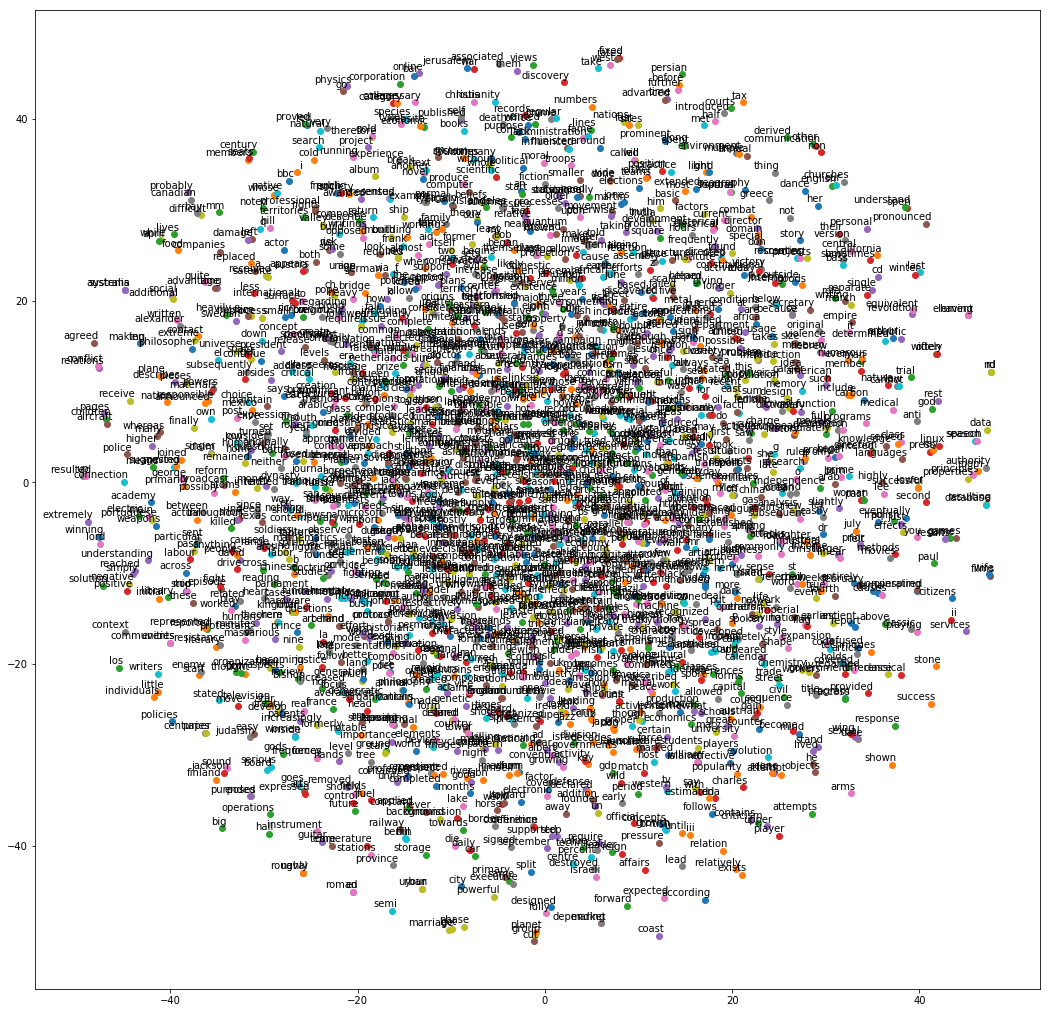

In [42]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

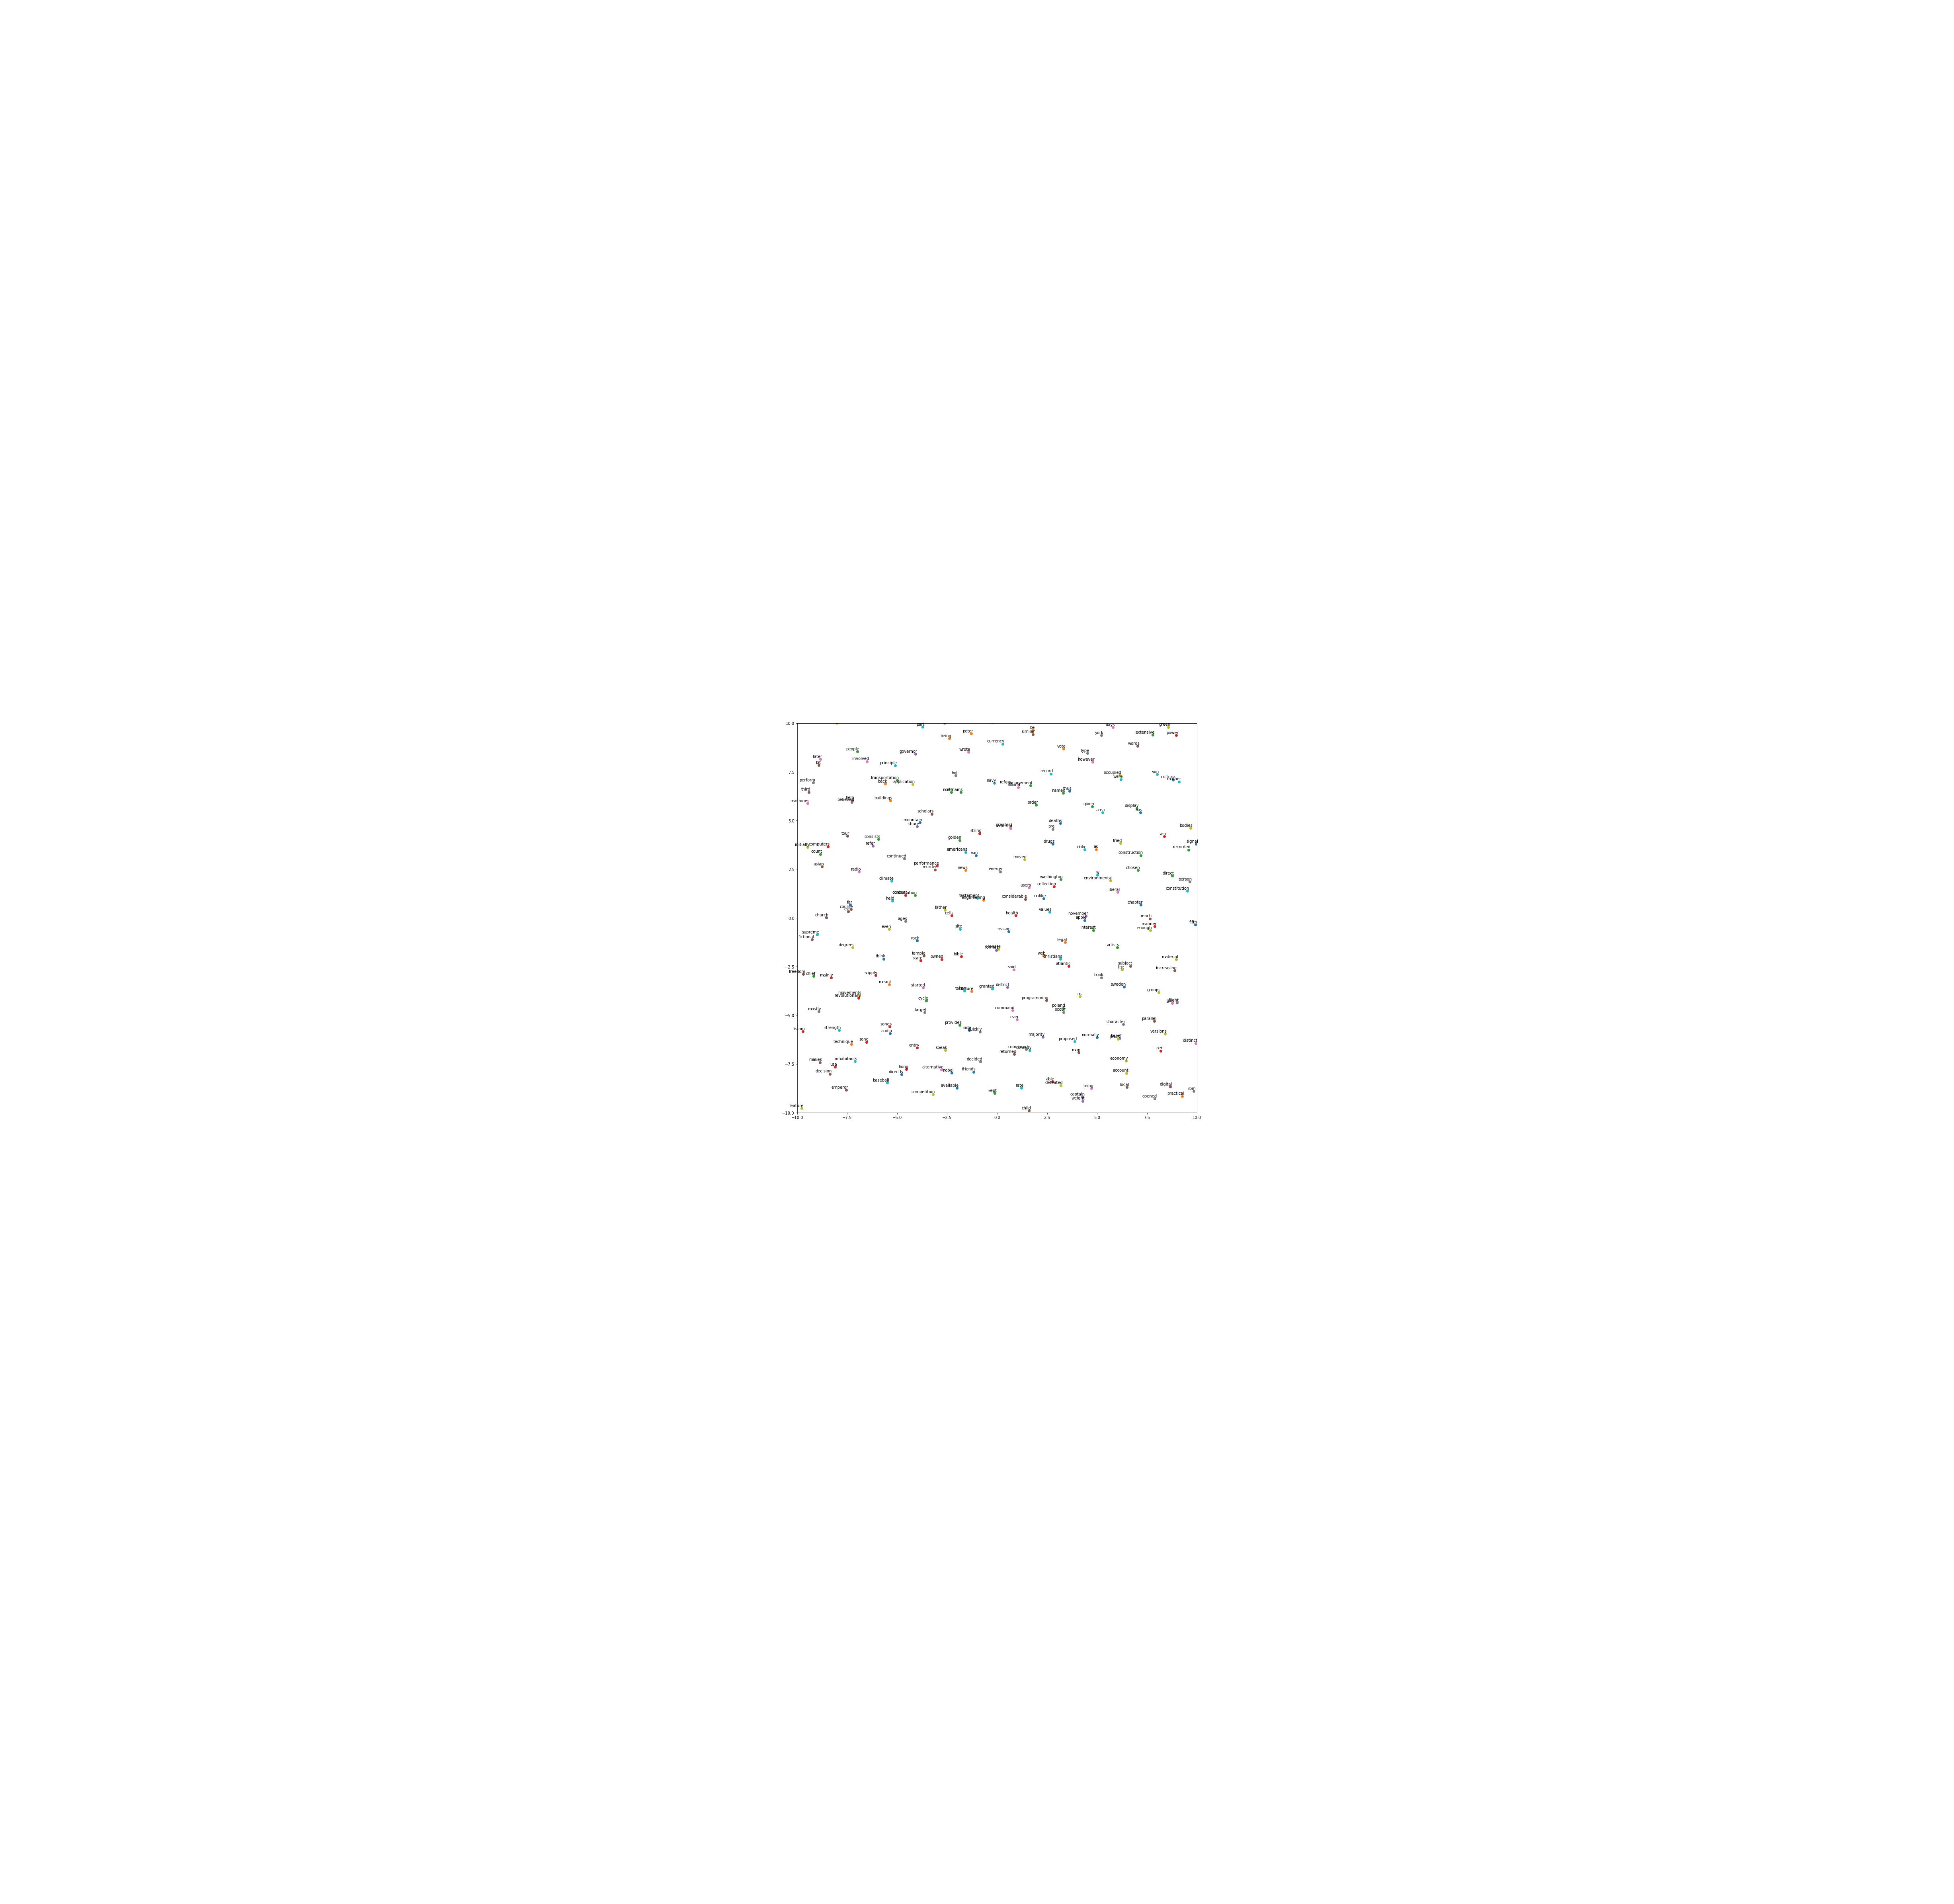

In [43]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

In [0]:
np.save('trained_embeddings_200k_steps',final_embeddings)